I had the idea to apply distributed word vectors ([word2vec]( https://en.wikipedia.org/wiki/Word2vec)) to this dataset. 

Word2vec, in a very high level, is an algorithm capable to learn the relationship between words using the context (neighbouring words), and encodes those relatinships in a vector. Using these vectors, we can cluster the words in or library, or even do operations. The classic example of the latter is; "king - man + woman = queen."

Word2vec uses recurrent neural networks to learn, then usually works better with huge datasets (billions of words), but we will see how it performs with the cooking dataset, where each receipt will be a sentence. One of the best features of this algorithm published by Google is the speed. Other recurrent neural networks had been proposed, however they were insanely CPU time consuming. If you want more detailed information about this, I strongly suggest you to read about [here]( https://www.google.ca/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&cad=rja&uact=8&ved=0ahUKEwiU5PmPoOPSAhVn5IMKHcIUDmIQFggaMAA&url=https%3A%2F%2Fpapers.nips.cc%2Fpaper%2F5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf&usg=AFQjCNFvn2t3S41dxIocYbx5EpeOwmjXVQ&sig2=IxYxjFBtWI_BkYLKymPAsw&bvm=bv.149760088,d.amc), [here]( https://www.quora.com/How-does-word2vec-work) and [here]( https://blog.acolyer.org/2016/04/21/the-amazing-power-of-word-vectors/) : . Now let’s tackle our dataset. 


In [1]:
from __future__ import print_function

# Handle data
import json
import operator
import collections
import re

# Handle table-like data 
import numpy as np
import pandas as pd

# Model Algorithms
# we could use also tensor flow, there are multiple implementations of word2vec
from gensim.models import word2vec

# Modelling Helpers, see above the description
from sklearn.manifold import TSNE

# Visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
%matplotlib inline

In [2]:
# Load the dataset
# json format labels: cuisine, id number and ingredients (list)
trainrecipts = json.load(open('./data/train.json','r'))

## General Exploration of the Dataset

Although this dataset is probably quite clean, do a general exploration of our data is really good habit, no matter what kind of model you will apply to them. Plot a few frequencies and means can provide a value information of all sorts about potential problems, bias, typos, etc.

In [3]:
# Quick&dirty code to extract info2list
raw_ingredients = list()

for recipt in trainrecipts:
    for ingredient in recipt[u'ingredients']:
        raw_ingredients.append(ingredient.strip())
        

raw_cuisines = list()
for recipt in trainrecipts:
    raw_cuisines.append(recipt[u'cuisine'].strip())



In [5]:
# use Counter to get frequencies 
counts_ingr = collections.Counter(raw_ingredients)
counts_cuis = collections.Counter(raw_cuisines)

### Cuisines

In [6]:
# this will help us to have an idea how our corpora of 
# ingredients looks like
print('Size Ingredients dataset (with repetition):  \t{}'.format((len(raw_ingredients))))
print('Unique Ingredients dataset: \t\t\t{}'.format((len(counts_ingr.values()))))

# This will provide a distribution of cusines, indirect 
# info of the ingredients
print('Total # of recipts \t\t\t\t{}'.format(len(raw_cuisines)))
print('Total # of Cuisines \t\t\t\t{}'.format((len(counts_cuis.values()))))



Size Ingredients dataset (with repetition):  	428275
Unique Ingredients dataset: 			6714
Total # of recipts 				39774
Total # of Cuisines 				20


In [7]:
# top 10
counts_cuis.most_common(10)

[('italian', 7838),
 ('mexican', 6438),
 ('southern_us', 4320),
 ('indian', 3003),
 ('chinese', 2673),
 ('french', 2646),
 ('cajun_creole', 1546),
 ('thai', 1539),
 ('japanese', 1423),
 ('greek', 1175)]

In [8]:
# Distribution 

print(np.mean(list(counts_cuis.values())))
print(np.std(list(counts_cuis.values())))

1988.7
1989.865349715905


findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


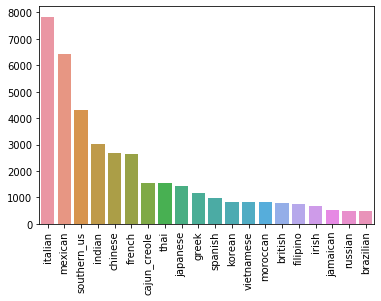

In [9]:
# lets plot this 
# sort
x_cu = [cu for cu, frq in counts_cuis.most_common()]
y_frq = [frq for cu, frq in counts_cuis.most_common()]
fbar = sns.barplot(x = x_cu, y = y_frq)
# xlabels
for item in fbar.get_xticklabels():
    item.set_rotation(90)

For instance, as we can see in the first plot, Italian and Mexican receipts represent more than a third of the entire dataset. So, it is probable that this will affect how our vectors form. It is good to keep this on mind for this or any other further model we apply to this dataset. Let’s check if there is a bias on the size of the receipts. 



### Ingredients

Other interesting parameter is the size of the receipts, how long are they? there is any bias?

In [10]:
# init a dict with a empty list
num_ingredients = dict(zip(counts_cuis.keys(), [list() for x in counts_cuis.keys()]))
for recipt in trainrecipts:
    # append the number in the list
    num_ingredients[recipt['cuisine']].append(len(recipt['ingredients']))

len(num_ingredients)

20

In [11]:
for cu, frq in num_ingredients.items():

    print('{}    \t\t{:.2f}'.format(cu, np.mean(frq)))

greek    		10.18
southern_us    		9.63
filipino    		10.00
indian    		12.71
jamaican    		12.21
spanish    		10.42
italian    		9.91
mexican    		10.88
chinese    		11.98
british    		9.71
thai    		12.55
vietnamese    		12.68
cajun_creole    		12.62
brazilian    		9.52
french    		9.82
japanese    		9.74
irish    		9.30
korean    		11.28
moroccan    		12.91
russian    		10.22


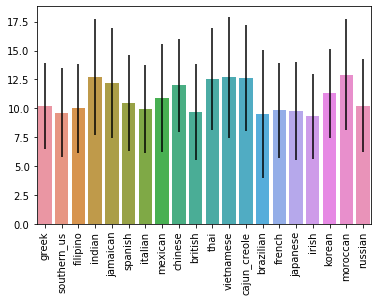

In [12]:
x_cu = [cu for cu, frq in num_ingredients.items()]
y_frq = [np.mean(frq) for cu, frq in num_ingredients.items()]
err = [np.std(frq) for cu, frq in num_ingredients.items()]
fbar = sns.barplot(x = x_cu, y = y_frq, yerr=err)
# xlabels
for item in fbar.get_xticklabels():
    item.set_rotation(90)

Well, on terms of size, all the receipts appear to be more similar. Then, let’s focus on the ingredients. As I mentioned above, I guess this dataset is really clean, or at least more than a real-world dataset and I do not expect any pre-processing. Also, full disclaimer, I did not check any of the models submitted to kaggel, and my intention is build the word2vec with as a proof of concept.

In [14]:
# Dispersion of the frequencies Ingredients
print(np.mean(list(counts_ingr.values())))
print(np.std(list(counts_ingr.values())))

63.7883526958594
388.3270259662557


The frequency of the ingredients presents a similar scenario, a few ingredients are tremendously popular. Make sense, some ingredients as salt, or water are common in any recipes.  Half of the ingredients only appear 4 or less times in the dataset, that is wide less what I expected. Let's check the most popular.

In [15]:
# This is to big to plot, let's check the percentiles
print(np.median(list(counts_ingr.values())))
print(np.percentile(list(counts_ingr.values()), [25., 50., 75., 99.]))

4.0
[1.00000e+00 4.00000e+00 2.00000e+01 1.15644e+03]


Half of the ingredients only appear 4 or less times in the dataset, that is wide less what I expected. Let's check the most populars.

In [16]:
# top 15
counts_ingr.most_common(15)

[('salt', 18049),
 ('onions', 7972),
 ('olive oil', 7972),
 ('water', 7457),
 ('garlic', 7380),
 ('sugar', 6434),
 ('garlic cloves', 6237),
 ('butter', 4848),
 ('ground black pepper', 4785),
 ('all-purpose flour', 4632),
 ('pepper', 4438),
 ('vegetable oil', 4385),
 ('eggs', 3388),
 ('soy sauce', 3296),
 ('kosher salt', 3113)]

A few ingredients like Salt and water make a lot of sense that they are highly frequent, but the present of olive oil among these omnipresent ingredients make me think that is an artefact of the bias of the dataset to the Italian cooking.

In [17]:
# Tail 50
counts_ingr.most_common()[-50:]

[('tonic water', 1),
 ('Chartreuse Liqueur', 1),
 ('aloe juice', 1),
 ('salt free chili powder', 1),
 ('tofu sour cream', 1),
 ('spicy salami', 1),
 ('Honeysuckle Whiteﾂｮ Hot Italian Turkey Sausage Links', 1),
 ('chocolate extract', 1),
 ('chocolate graham crackers', 1),
 ('cumberland sausage', 1),
 ('cocktail pumpernickel bread', 1),
 ('chunky tomatoes', 1),
 ("Colman's Mustard Powder", 1),
 ('manouri', 1),
 ('cherry vanilla ice cream', 1),
 ('bone-in ribeye steak', 1),
 ('frozen lemonade concentrate, thawed and undiluted', 1),
 ('flowering chinese chives', 1),
 ('praline topping', 1),
 ('riblets', 1),
 ('puff paste', 1),
 ('Barilla Plus Pasta', 1),
 ('turkey giblet stock', 1),
 ('light chicken stock', 1),
 ('conchiglie', 1),
 ('2% milk shredded mozzarella cheese', 1),
 ('Makers Mark Whisky', 1),
 ('knorr pasta side   cheesi cheddar', 1),
 ('whole grain baguette', 1),
 ('reduced sodium ham', 1),
 ('whole wheat peasant bread', 1),
 ('ranch-style seasoning', 1),
 ('ketjap', 1),
 ('choco

There are some very specific ingredients... I expect that some of those are typos, or just versions of other ingredients. Also notice that in the dataset the same ingredient can present in different formats, garlic, and garlic cloves. First a quick search for parenthesis or similar symbols that rise a red flag to typos, or weird writing


In [18]:
symbols = list()

for recipt in trainrecipts:

    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        if re.match("\(|@|\$\?", ingredient.lower()):
            symbols.append(ingredient)
len(symbols)
counts_symbols = collections.Counter(symbols)
counts_symbols.most_common(20)

[('(    oz.) tomato sauce', 11),
 ('(   oz.) tomato paste', 9),
 ('(14.5 oz.) diced tomatoes', 3),
 ('(15 oz.) refried beans', 3),
 ('(10 oz.) frozen chopped spinach', 3),
 ('(10 oz.) frozen chopped spinach, thawed and squeezed dry', 2),
 ('(14 oz.) sweetened condensed milk', 2)]

Well, I guess some pre-processing could be good, but let's see how our model behave. Let's train the neural network with a raw version of the dataset.

# Word2Vec

In [19]:
sentences = list()
# one hot ingredients

for recipt in trainrecipts:
    clean_recipt = list()
    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        # remove this description from the ingredients
        # minimal preprocessing
        ingredient =  re.sub(r'\(.*oz.\)|crushed|crumbles|ground|minced|powder|chopped|sliced',
                             '', 
                             ingredient)
        clean_recipt.append(ingredient.strip())
    sentences.append(clean_recipt)
        
len(sentences)

39774

In [20]:
# Set values for NN parameters
num_features = 300    # Word vector dimensionality                      
min_word_count = 3    # 50% of the corpus                    
num_workers = 4       # Number of CPUs
context = 10          # Context window size; 
                      # let's use avg recipte size                                                                                  
downsampling = 1e-3   # threshold for configuring which 
                    # higher-frequency words are randomly downsampled

# Initialize and train the model 
model = word2vec.Word2Vec(sentences, workers=num_workers, \
            size=num_features, min_count = min_word_count, \
            window = context, sample = downsampling)

# If you don't plan to train the model any further, calling 
# init_sims will make the model much more memory-efficient.
model.init_sims(replace=True)

Once the model is train we can ask him a few questions, for example what is similar to feta cheese. Looks like all the ingredients are stuff that you expect to find with feta cheese, and looks like they belong to Greek cuisine.

In [21]:
## Results

In [22]:
model.most_similar(u'feta cheese')

D:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Python3.6-gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('kalamata', 0.9381769895553589),
 ('yellow tomato', 0.921214759349823),
 ('pita bread rounds', 0.9063198566436768),
 ('fresh oregano', 0.8985974788665771),
 ('pitas', 0.8961461782455444),
 ('olives', 0.8875998258590698),
 ('pitted kalamata olives', 0.8848749399185181),
 ('greek seasoning', 0.8833760023117065),
 ('pita bread', 0.8785839676856995),
 ('roasted red peppers', 0.8692474961280823)]

In [23]:
model.similarity('broccoli', 'bacon')



D:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Python3.6-gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.36311752

In [24]:
model.similarity('broccoli', 'carrots')



D:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Python3.6-gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.62861997

In [25]:
model.similarity('broccoli', u'mushrooms')

D:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Python3.6-gpu\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  """Entry point for launching an IPython kernel.


0.8130127

In [26]:
#['garlic', 'onion'], ['olive oil']
x = 'basil'
b= 'tomato sauce'
a = 'pasta'
predicted = model.most_similar([x, b], [a])[0][0]
print(" {} is to  {} as {} is to {} ".format(a, b, x, predicted))

 pasta is to  tomato sauce as basil is to lean  meat 


D:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Python3.6-gpu\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """


In [27]:
#['garlic', 'onion'], ['olive oil']
x = 'chicken'
b= 'broccoli'
a = 'bacon'
predicted = model.most_similar([x, b], [a])[0][0]
print(" {} is to  {} as {} is to {} ".format(a, b, x, predicted))

 bacon is to  broccoli as chicken is to chili sauce 


D:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Python3.6-gpu\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """


In [28]:
model.wv.most_similar_cosmul(positive=['chili', u'meat'], negative=['tomato sauce'])

[('tamarind paste', 1.2825576066970825),
 ('root vegetables', 1.280583381652832),
 ('peanut', 1.2682994604110718),
 ('coconut oil', 1.267699956893921),
 ('tamarind concentrate', 1.2519115209579468),
 ('cilantro leaves', 1.2399781942367554),
 ('chiles', 1.229215383529663),
 ('cilantro', 1.2285563945770264),
 ('tamarind pulp', 1.223090410232544),
 ('tamarind', 1.2222508192062378)]

# Viz with t-SNE

In [29]:
corpus = sorted(model.wv.vocab.keys()) #not sure the exact api
emb_tuple = tuple([model[v] for v in corpus])
X = np.vstack(emb_tuple)

D:\Users\301518\AppData\Local\Continuum\anaconda3\envs\Python3.6-gpu\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [30]:
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

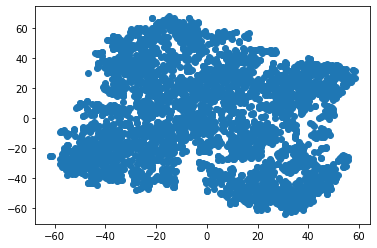

In [31]:
plt.scatter(X_tsne[:, 0], X_tsne[:, 1])

Looks like there are some clusters of ingredients but is difficult to say anything else without adding labels or colors. Let's start easy and color each ingredient by the cuisine where it is more frequent. May be not the best way, but one of the fastest approaches to test if this is working. I will normalize the frequency.

In [32]:
# I will label a ingredient by frequency 
track_ingredients = dict(zip(counts_cuis.keys(), [list() for x in counts_cuis.keys()]))
for recipt in trainrecipts:
    # append the number in the list
    clean_recipt = list()
    # I want ingredient remove 
    for ingredient in recipt['ingredients']:
        # remove this description from the ingredients
        # (10 oz.) 
        ingredient =  re.sub(r'crushed|crumbles|ground|minced|powder|chopped|sliced', '', ingredient)
        clean_recipt.append(ingredient.strip())
        
    track_ingredients[recipt['cuisine']].extend(clean_recipt)

for label, tracking in track_ingredients.items():
    track_ingredients[label] = collections.Counter(tracking)

In [33]:
def return_most_popular(v):
    cuisine = None
    record = 0
    for label, tracking in track_ingredients.items():
        norm_freq = float(tracking[v]) / float(counts_cuis[label])
        if norm_freq > record:
            cuisine = label
            record = norm_freq
    return cuisine

In [34]:
track_2color = {u'irish':"#000000", # blak
                u'mexican':"#FFFF00", #yellow
                u'chinese':"#1CE6FF", #cyan
                u'filipino': "#FF34FF", #pink 
                u'vietnamese':"#FF4A46", #red
                u'spanish':"#FFC300",  # green forest
                u'japanese':"#006FA6", # blue ocean
                u'moroccan':"#A30059",# purple
                u'french':"#FFDBE5",  #light pink
                u'greek': "#7A4900",  # gold or brown 
                u'indian':"#0000A6", # blue electric 
                u'jamaican':"#63FFAC", # green phospho
                u'british': "#B79762", #brown
                u'brazilian': "#EEC3FF", #  
                u'russian':"#8FB0FF", # light blue 
                u'cajun_creole':"#997D87", #violet
                u'thai':"#5A0007", 
                u'southern_us':"#809693", 
                u'korean':"#FEFFE6", #ligt yellow
                u'italian':"#1B4400"}

color_vector = list()
for v in corpus:
    cuisine = return_most_popular(v)
    color_vector.append(track_2color[cuisine])

In [35]:
# ensemble the legend
lgend = list()
for l, c in track_2color.items():
    lgend.append(mpatches.Patch(color=c, label=l))

findfont: Font family ['IPAexGothic'] not found. Falling back to DejaVu Sans.


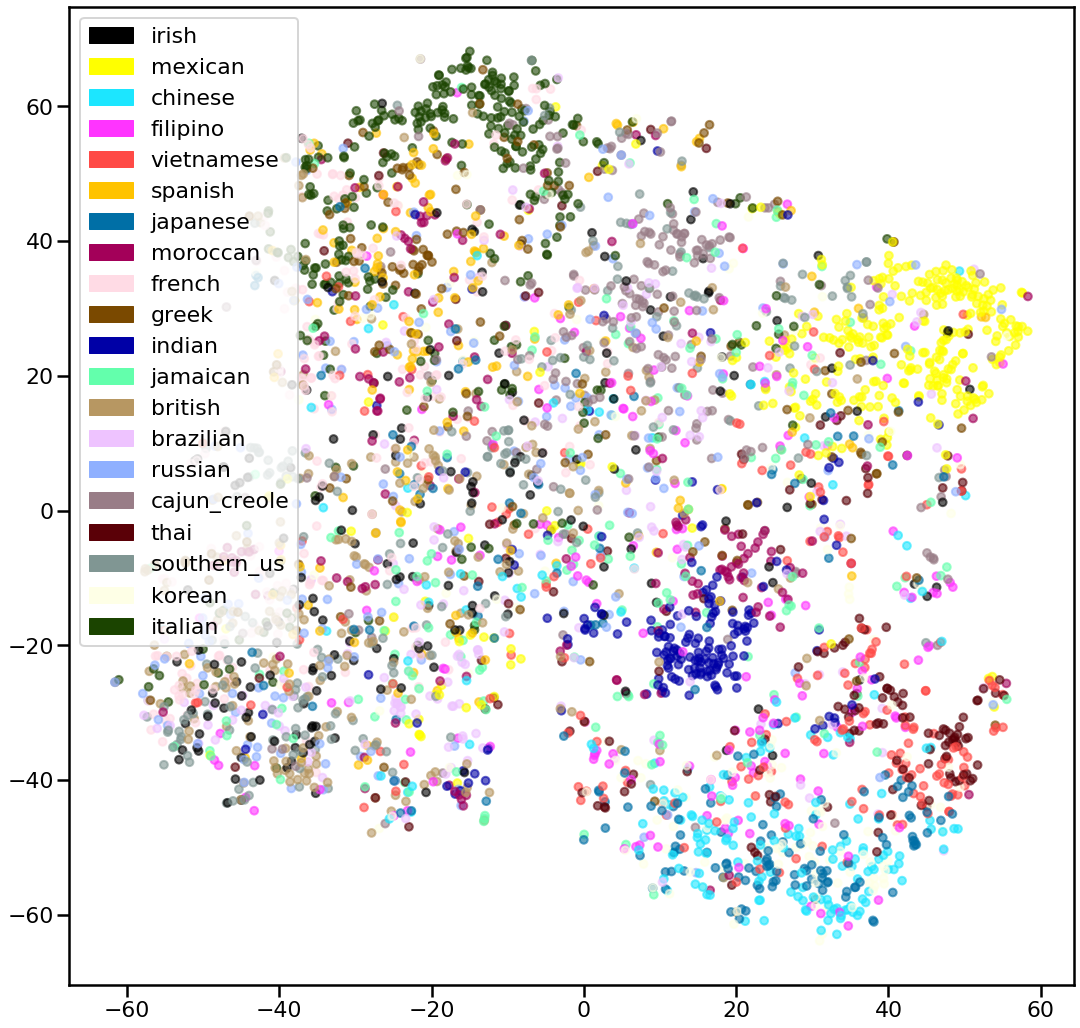

In [36]:
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(18,18))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=color_vector, alpha=.6, s=60)
plt.legend(handles=lgend)